In [1]:
import numpy as np
from scipy.stats import gamma,norm,poisson,bernoulli

data = []
with open('./premier_league_2013_2014.dat','r') as f:
    for x in f.readlines():
        line = []
        for num in x.strip().split(','):
            line.append(int(float(num)))
        data.append(line)

In [2]:
data = np.array(data)
# 380 * 4 
#yg0              yg1              h(g)              a(g)
#home team score  away team score  home team index  away team index

In [3]:
team_num = 20
game_num = 380
tau_1 = 0.01


def log_xmu(x_mu):
    return norm.logpdf(x_mu, loc=0., scale=1 / tau_1)

def log_xtau(x_tau):
    return gamma.logpdf(x_tau, 0.1, scale=10)

def log_attdef(params_5, atts, defs):
    mu_att = params_5[1]
    mu_def = params_5[2]
    tau_att = params_5[3]
    tau_def = params_5[4]
    result = 0
#     print(np.sum(norm.logpdf(atts, loc=mu_att, scale=np.sqrt(tau_att))))
#     print(np.sum(norm.logpdf(defs, loc=mu_def, scale=np.sqrt(tau_def))))
    result += np.sum(norm.logpdf(atts[1:], loc=mu_att, scale=1 / np.sqrt(tau_att)))
    result += np.sum(norm.logpdf(defs[1:], loc=mu_def, scale=1 / np.sqrt(tau_def)))
    return result

def log_y(theta, observed):
    result = 0
    result += np.sum(poisson.logpmf(observed[:,0], theta[:,0]))
    result += np.sum(poisson.logpmf(observed[:,1], theta[:,1]))
    return result
    

def generate_theta(team_index, home, atts, defs):
    attack_h = [atts[i[0]] for i in team_index]
    defense_h = [defs[i[0]] for i in team_index]
    attack_a = [atts[i[1]] for i in team_index]
    defense_a = [defs[i[1]] for i in team_index]
    theta = np.zeros((game_num, 2))
    for i in range(game_num):
        theta[i][0] = np.exp(home + attack_h[i] - defense_a[i])
        theta[i][1] = np.exp(attack_a[i] - defense_h[i])
#     print(theta)
    return theta


#home, mu_att, mu_def, tau_att, tau_def, atts, defs
def log_jointp(params, observed = data[:,0:2]):
    jointp = 0
    home= params[0]
    atts = params[5:25]
    defs = params[25:45]
    jointp += log_xmu(params[0])
    jointp += log_xmu(params[1])
    jointp += log_xmu(params[2])
    jointp += log_xtau(params[3])
    jointp += log_xtau(params[4])
#     print(jointp)
    jointp += log_attdef(params[0:5], atts, defs)
#     print(jointp)
    theta = generate_theta(data[:,2:4], home, atts, defs)
    jointp += log_y(theta, observed)
    return jointp
  

In [4]:
# print(log_jointp(params))
def MCMC(sigma, t, step = 5001):
    params = np.ones((45)) * 0.1
    params[25] = 0
    params[5] = 0
    result = []
    reject_num = 0
    log_joint = log_jointp(params)
    for i in range(step * t):
        new_params = np.random.normal(params, sigma, size=(45))
        new_params[5] = 0
        new_params[25] = 0
        new_params[3] = max(0.001, new_params[3])
        new_params[4] = max(0.001, new_params[4])
        new_log_joint = log_jointp(new_params)
        threshold = np.exp(min(0, new_log_joint - log_joint))
        if bernoulli.rvs(threshold) == 1:
            params = new_params
            log_joint = new_log_joint
        else:
            reject_num += 1
        if i != 0 and i % t == 0:
            result.append(params)
    return result, reject_num / (step*t)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline 
def plot(samples, sigmai, ti):
    result = np.mean(samples, axis=0)
    att = result[5:25]
    defs = result[25:45]
    plt.scatter(defs, att)
    for i in range(20):
        plt.text(defs[i], att[i], str(i))
    params = '_' + str(sigmai) + '_' + str(ti) + '.png'
    plt.xlabel('defense')
    plt.ylabel('attack')
    plt.savefig("./figures/scatter" + params)
    plt.show()
    samples = np.array(samples)
    x_i = np.arange(samples.shape[0])
    home = samples[:,0]
    plt.plot(x_i, home)
    plt.savefig("./figures/trace" + params)
    plt.show()
    plt.hist(home, bins=30)
    plt.savefig("./figures/histo" + params)
    plt.show()
    return

Starting expriments on t = 1, sigma = 0.005000


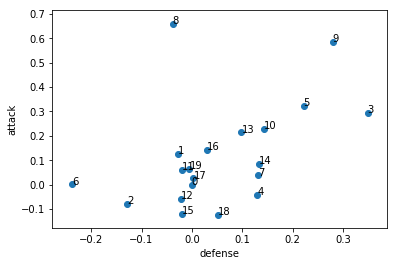

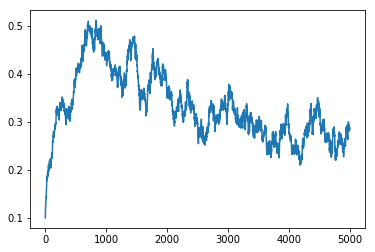

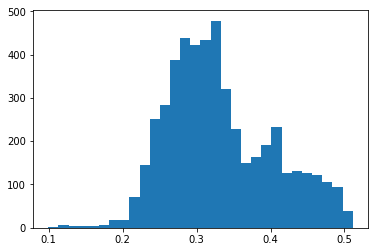

rejection rate is 0.142372
Starting expriments on t = 1, sigma = 0.050000


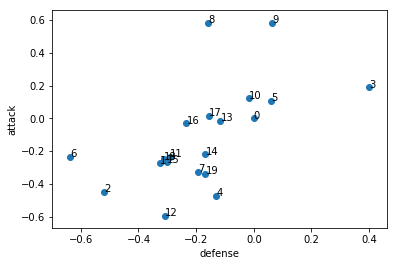

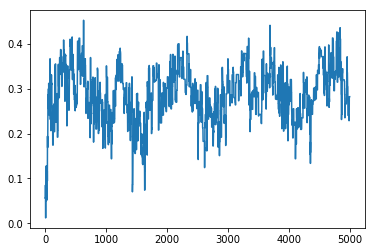

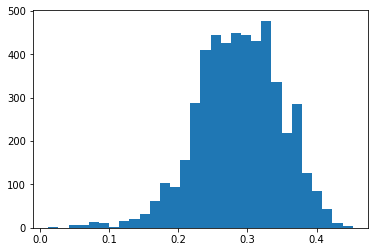

rejection rate is 0.797840
Starting expriments on t = 5, sigma = 0.005000


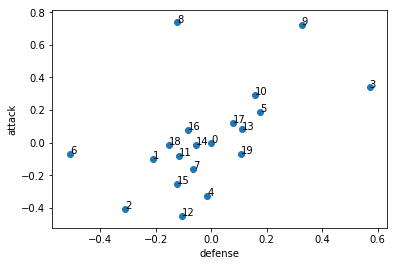

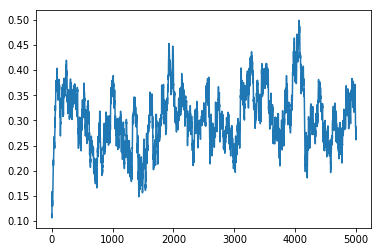

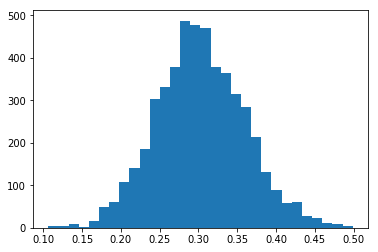

rejection rate is 0.106659
Starting expriments on t = 5, sigma = 0.050000


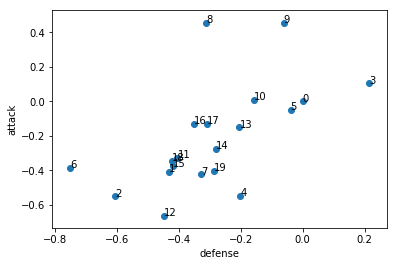

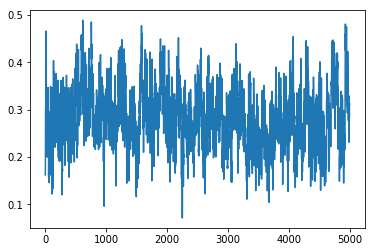

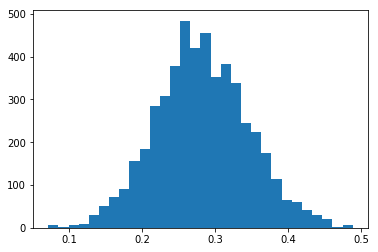

rejection rate is 0.814197
Starting expriments on t = 20, sigma = 0.005000


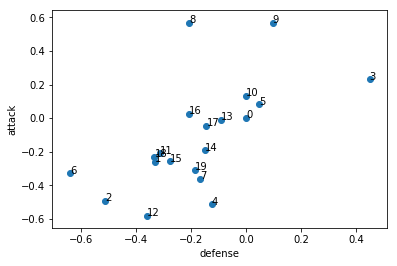

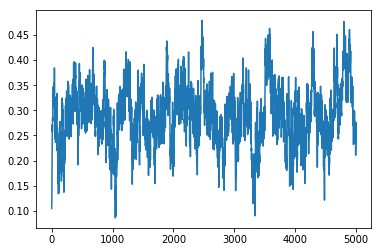

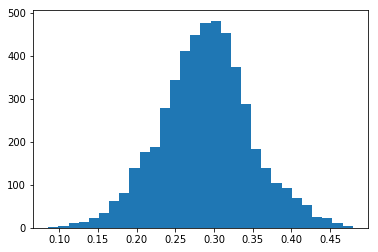

rejection rate is 0.104629
Starting expriments on t = 20, sigma = 0.050000


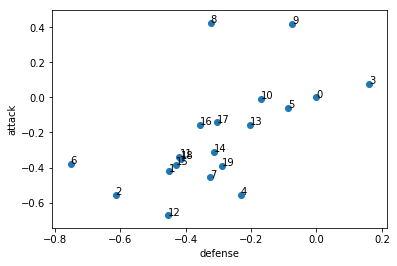

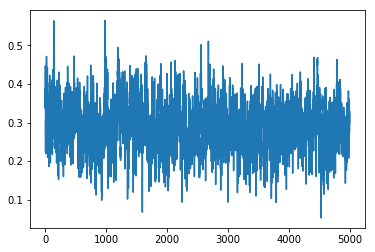

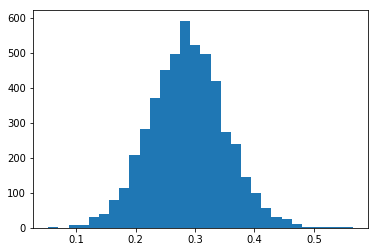

rejection rate is 0.836033
Starting expriments on t = 50, sigma = 0.005000


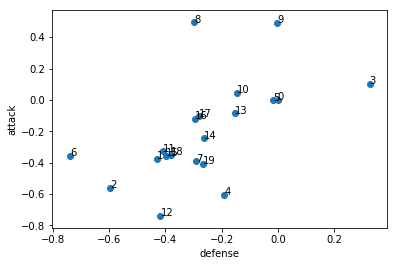

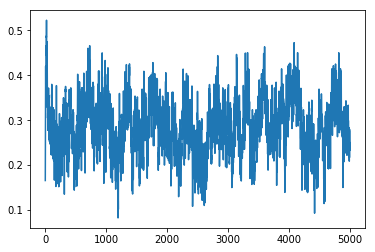

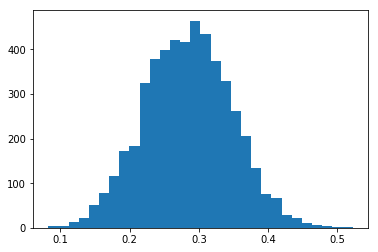

rejection rate is 0.105239
Starting expriments on t = 50, sigma = 0.050000


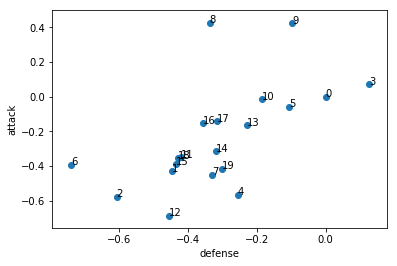

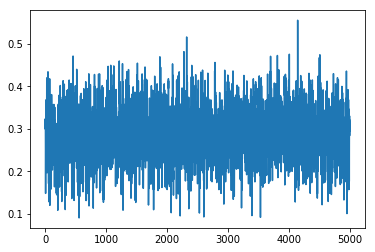

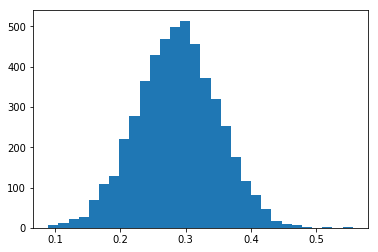

rejection rate is 0.840732


In [9]:
t = [1,5,20,50]
sigma = [0.005, 0.05]
rejects = []
for ti in t:
    for sigmai in sigma:
        print("Starting expriments on t = %d, sigma = %f" %(ti, sigmai))
        samples, reject_ratio = MCMC(sigmai, ti)
        plot(samples, sigmai, ti)
        print("rejection rate is %f" % (reject_ratio))
        rejects.append(reject_ratio)

Starting expriments on t = 1, sigma = 0.500000


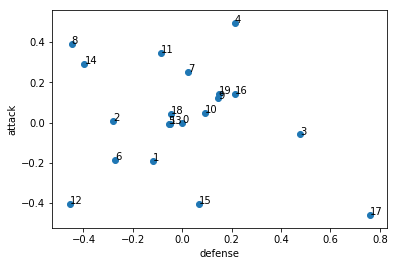

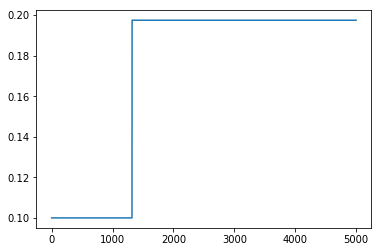

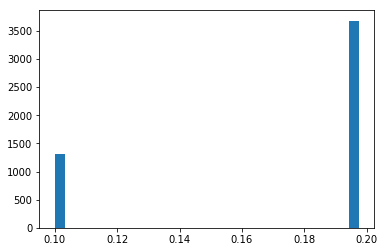

rejection rate is 0.999800
Starting expriments on t = 5, sigma = 0.500000


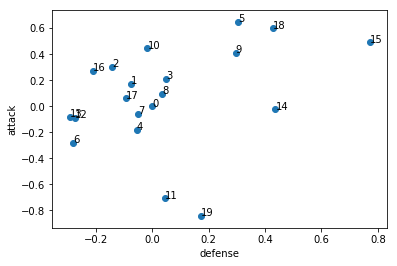

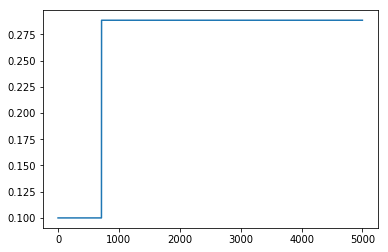

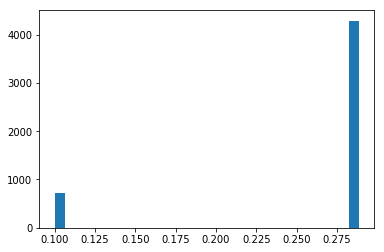

rejection rate is 0.999960
Starting expriments on t = 20, sigma = 0.500000


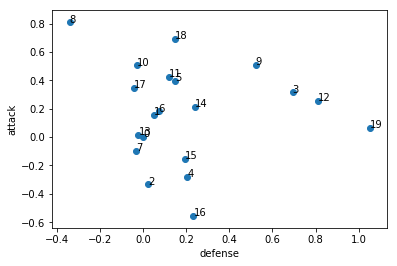

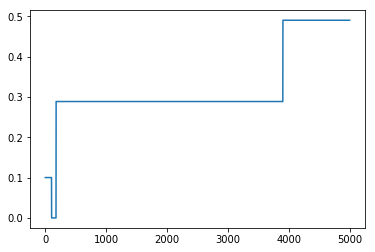

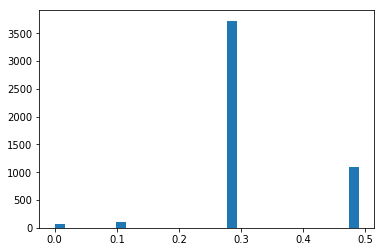

rejection rate is 0.999970
Starting expriments on t = 50, sigma = 0.500000


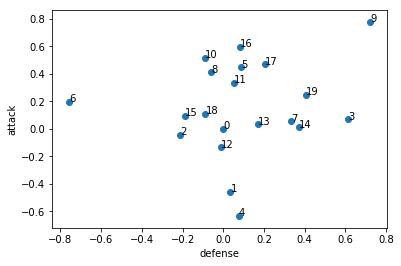

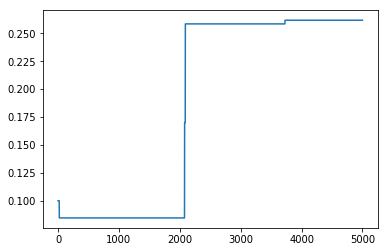

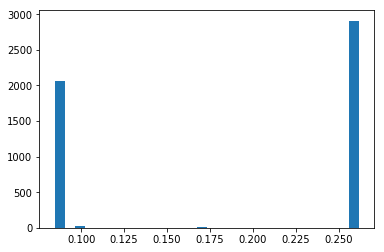

rejection rate is 0.999984


In [10]:
t = [1,5,20,50]
sigma = [0.5]
rejects = []
for ti in t:
    for sigmai in sigma:
        print("Starting expriments on t = %d, sigma = %f" %(ti, sigmai))
        samples, reject_ratio = MCMC(sigmai, ti)
        plot(samples, sigmai, ti)
        print("rejection rate is %f" % (reject_ratio))
        rejects.append(reject_ratio)